## Prediction of accident number by category and time
#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from neuralprophet import NeuralProphet, save, load
import itertools
import logging
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

/u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Load dataset
The number of accidents for different categories per month.

In [2]:
df = pd.read_csv('./data/monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      2016 non-null   object 
 1   AUSPRAEGUNG                     2016 non-null   object 
 2   JAHR                            2016 non-null   int64  
 3   MONAT                           2016 non-null   int64  
 4   WERT                            1848 non-null   float64
 5   VORJAHRESWERT                   1848 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 141.9+ KB


#### Data cleaning
Drop NaNs in "WERT".

In [3]:
df.dropna(axis=0, subset=['WERT'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      1848 non-null   object 
 1   AUSPRAEGUNG                     1848 non-null   object 
 2   JAHR                            1848 non-null   int64  
 3   MONAT                           1848 non-null   int64  
 4   WERT                            1848 non-null   float64
 5   VORJAHRESWERT                   1764 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 130.1+ KB


Check for duplicates.

In [5]:
print(df.duplicated().any())

False


Convert the format of "MONAT" to datetime.

In [4]:
df['MONAT'] = pd.to_datetime(df['MONAT'], format='%Y%m', errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   MONATSZAHL                      1848 non-null   object        
 1   AUSPRAEGUNG                     1848 non-null   object        
 2   JAHR                            1848 non-null   int64         
 3   MONAT                           1848 non-null   datetime64[ns]
 4   WERT                            1848 non-null   float64       
 5   VORJAHRESWERT                   1764 non-null   float64       
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64       
 7   VERAEND_VORJAHRESMONAT_PROZENT  1763 non-null   float64       
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 130.1+ KB


#### Data preprocessing
Split data into train and test set (train set: all data before 2020, test set: data after 2020).

In [13]:
data = df.copy()

data_train = data[data['MONAT'] < '2021-01-01']
data_train.reset_index(drop=True, inplace=True)
print(data_train.shape)

data_test = data[data['MONAT'] >= '2021-01-01']
data_test.reset_index(drop=True, inplace=True)
print(data_test.shape)
data_test.head()

(1764, 9)
(84, 9)


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2021,2021-01-01,16.0,28.0,23.08,-42.86,35.0
1,Alkoholunfälle,insgesamt,2021,2021-02-01,14.0,40.0,-12.50,-65.00,33.0
2,Alkoholunfälle,insgesamt,2021,2021-03-01,24.0,27.0,71.43,-11.11,32.0
3,Alkoholunfälle,insgesamt,2021,2021-04-01,16.0,26.0,-33.33,-38.46,32.0
4,Alkoholunfälle,insgesamt,2021,2021-05-01,24.0,40.0,50.00,-40.00,30.0


Split data per category (Verkehrsunfälle, Alkoholunfälle, Fluchtunfälle).

In [74]:
data = df.copy()

data_alk = data[data['MONATSZAHL'] == 'Alkoholunfälle']
data_alk.reset_index(drop=True, inplace=True)
print(data_alk['AUSPRAEGUNG'].value_counts())
print(data_alk.shape)

data_flu = data[data['MONATSZAHL'] == 'Fluchtunfälle']
data_flu.reset_index(drop=True, inplace=True)
print(data_flu['AUSPRAEGUNG'].value_counts())
print(data_flu.shape)

data_ver = data[data['MONATSZAHL'] == 'Verkehrsunfälle']
data_ver.reset_index(drop=True, inplace=True)
print(data_ver['AUSPRAEGUNG'].value_counts())
print(data_ver.shape)

insgesamt                 264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(528, 9)
insgesamt                 264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(528, 9)
insgesamt                 264
mit Personenschäden       264
Verletzte und Getötete    264
Name: AUSPRAEGUNG, dtype: int64
(792, 9)


Keep "WERT" and drop irrelevant columns.

In [6]:
data = df.copy()

data_wert = data[['MONATSZAHL', 'AUSPRAEGUNG', 'MONAT', 'WERT']]
data_wert.reset_index(drop=True, inplace=True)
data_wert.head()

,MONATSZAHL,AUSPRAEGUNG,MONAT,WERT
0,Alkoholunfälle,insgesamt,2021-01-01,16.0
1,Alkoholunfälle,insgesamt,2021-02-01,14.0
2,Alkoholunfälle,insgesamt,2021-03-01,24.0
3,Alkoholunfälle,insgesamt,2021-04-01,16.0
4,Alkoholunfälle,insgesamt,2021-05-01,24.0


#### Prediction of accident number by category and time
1. Univariate time series model (NeuralProphet).

A Univariate time series model takes only two inputs: the datetime and the variable. Further process the dataset to fulfill this constrain.

In [5]:
data = df.copy()

data_grouped = data.groupby(['MONATSZAHL', 'AUSPRAEGUNG'])

df_names = ['data_alk_ins', 'data_alk_vug', 'data_flu_ins', 'data_flu_vug', 'data_ver_ins', 'data_ver_mps', 'data_ver_vug']
df_list = []

for i in range(len(data.MONATSZAHL.unique())):
    data_tmp = data[data['MONATSZAHL'] == data.MONATSZAHL.unique()[i]]
    for j in range(len(data_tmp.AUSPRAEGUNG.unique())):
        data_tmp_2 = data_grouped.get_group((data.MONATSZAHL.unique()[i], data_tmp.AUSPRAEGUNG.unique()[j]))
        data_tmp_2.sort_values(by='MONAT', inplace=True, ascending=False)
        df_names[i+j] = data_tmp_2[['MONAT', 'WERT']]
        df_names[i+j].sort_values(by='MONAT', inplace=True, ascending=False)
        df_names[i+j].reset_index(drop=True, inplace=True)
        df_list.append(df_names[i+j])
        print(df_names[i+j].head())

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3530438/265285068.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tmp_2.sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3530438/265285068.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names[i+j].sort_values(by='MONAT', inplace=True, ascending=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3530438/265285068.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

       MONAT  WERT
0 2021-12-01  21.0
1 2021-11-01  33.0
2 2021-10-01  43.0
3 2021-09-01  54.0
4 2021-08-01  46.0
       MONAT  WERT
0 2021-12-01   7.0
1 2021-11-01  15.0
2 2021-10-01  27.0
3 2021-09-01  36.0
4 2021-08-01  24.0
       MONAT    WERT
0 2021-12-01   788.0
1 2021-11-01   849.0
2 2021-10-01  1053.0
3 2021-09-01   951.0
4 2021-08-01   715.0
       MONAT  WERT
0 2021-12-01  17.0
1 2021-11-01  55.0
2 2021-10-01  52.0
3 2021-09-01  78.0
4 2021-08-01  41.0
       MONAT    WERT
0 2021-12-01  2997.0
1 2021-11-01  3308.0
2 2021-10-01  3861.0
3 2021-09-01  3651.0
4 2021-08-01  2857.0
       MONAT   WERT
0 2021-12-01  284.0
1 2021-11-01  368.0
2 2021-10-01  492.0
3 2021-09-01  594.0
4 2021-08-01  449.0
       MONAT   WERT
0 2021-12-01  340.0
1 2021-11-01  430.0
2 2021-10-01  561.0
3 2021-09-01  678.0
4 2021-08-01  531.0


Try with category "Alkoholunfälle" and type "insgesamt".

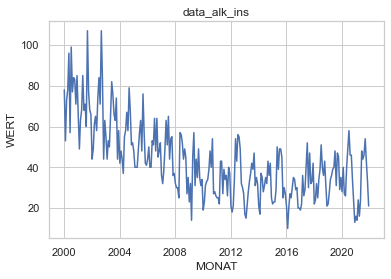

In [6]:
sns.set(rc={'figure.figsize':(8, 4)})
sns.set_style("whitegrid")

sns.lineplot(x='MONAT', y='WERT', data=df_list[0]).set_title('data_alk_ins')
plt.show()

Split data into train(<=2020) and test(>2020) set.

In [7]:
data = df_list[0].copy()
data.columns = ['ds', 'y']

data_train_val = data[data['ds'] < '2021-01-01']
data_train_val.reset_index(drop=True, inplace=True)
print(data_train_val.shape)
data_test = data[data['ds'] >= '2021-01-01']
data_test.reset_index(drop=True, inplace=True)
print(data_test.shape)

(252, 2)
(12, 2)


Train model.

In [8]:
model = NeuralProphet(yearly_seasonality=True, seasonality_mode='additive', normalize='minmax')

data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.1)
print("Dataset size:", len(data))
print("Train dataset size:", len(data_train))
print("Validation dataset size:", len(data_val))

model = model.add_country_holidays(country_name='DE')
model.set_plotting_backend('plotly-static')
metrics_train = model.fit(data_train, validation_df=data_val, freq='MS', batch_size=3, epochs=300, early_stopping=False, learning_rate=0.008, progress=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.937% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.709% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CB

Dataset size: 264
Train dataset size: 227
Validation dataset size: 25


INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



In [9]:
metrics_train

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,209.026855,220.121475,1.002458,0.0,0,236.411850,243.389923,1.758231,0.0
1,203.178635,214.573242,0.972312,0.0,1,224.759354,231.189514,1.661612,0.0
2,197.468002,209.128189,0.942876,0.0,2,212.826172,219.585556,1.565264,0.0
3,191.570480,203.427933,0.912477,0.0,3,200.833160,207.997330,1.466806,0.0
4,185.454529,197.641312,0.880951,0.0,4,188.357864,195.897736,1.364250,0.0
...,...,...,...,...,...,...,...,...,...
295,11.110416,12.964005,0.014885,0.0,295,5.497146,6.470892,0.006507,0.0
296,11.117565,12.972339,0.014904,0.0,296,5.482783,6.562014,0.006491,0.0
297,11.122803,12.974767,0.014910,0.0,297,5.490479,6.413148,0.006500,0.0
298,11.107094,12.969739,0.014898,0.0,298,5.481911,6.371173,0.006474,0.0


Visualize training and validation loss.

Text(0, 0.5, 'Loss')

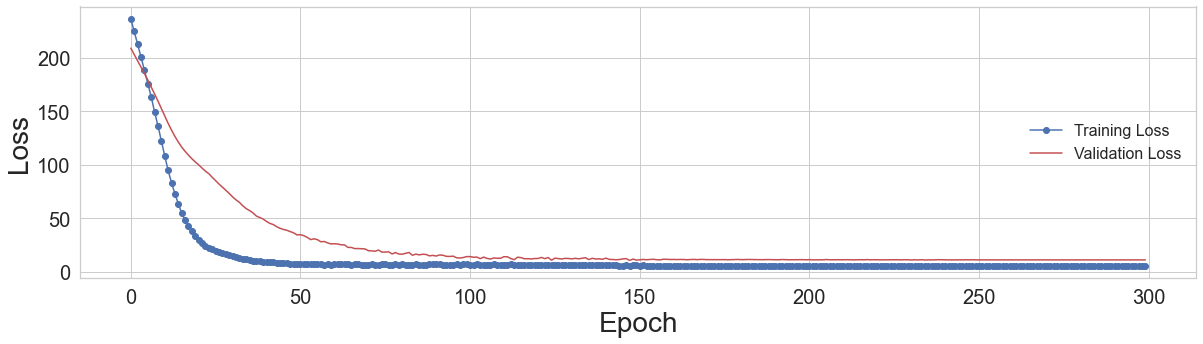

In [10]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(metrics_train["MAE"], '-o', label="Training Loss")  
ax.plot(metrics_train["MAE_val"], '-r', label="Validation Loss")
ax.legend(loc='center right', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Epoch", fontsize=28)
ax.set_ylabel("Loss", fontsize=28)

Test eveluation.

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


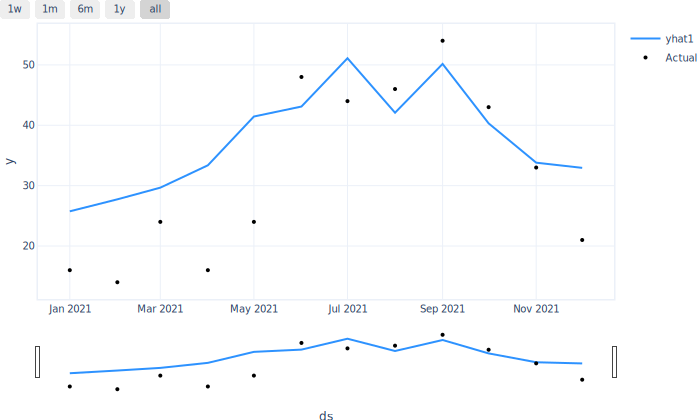

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 50.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01737513579428196
         MAE_val             8.263655662536621
        RMSE_val             9.904019355773926
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,8.263656,9.904019,0.017375,0.0


In [11]:
forecast = model.predict(data_test)
model.plot(forecast)

metrics_test = model.test(data_test)
metrics_test

Predict into future.

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.937% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.638]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.
INFO - (NP.df_utils.return_df_in_original_format) - Retur

            ds     y
0   2000-01-01  78.0
1   2000-02-01  53.0
2   2000-03-01  73.0
3   2000-04-01  78.0
4   2000-05-01  96.0
..         ...   ...
271 2022-08-01   NaN
272 2022-09-01   NaN
273 2022-10-01   NaN
274 2022-11-01   NaN
275 2022-12-01   NaN

[276 rows x 2 columns]
            ds     y      yhat1      trend  season_yearly  events_additive  \
0   2000-01-01  78.0  58.748901  55.235043    -115.451324       118.965187   
1   2000-02-01  53.0  57.593502  55.053837       2.539668         0.000000   
2   2000-03-01  73.0  61.620647  54.884315       6.736331         0.000000   
3   2000-04-01  78.0  65.404915  54.703102      10.701811         0.000000   
4   2000-05-01  96.0  72.893021  54.527740     -30.338049        48.703335   
..         ...   ...        ...        ...            ...              ...   
271 2022-08-01   NaN  43.308640  24.517380      18.791260         0.000000   
272 2022-09-01   NaN  51.491001  24.632540      26.858461         0.000000   
273 2022-10-01   NaN  

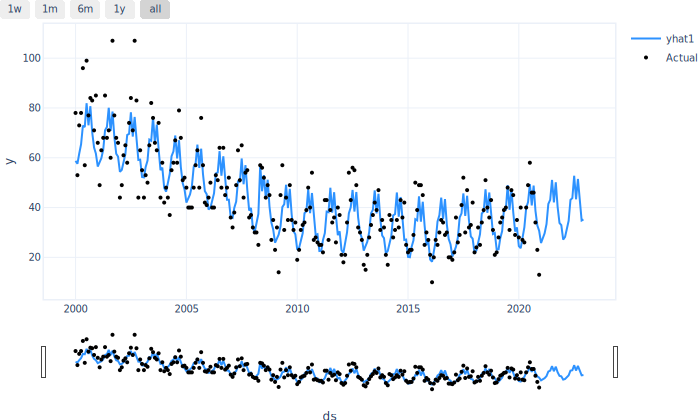

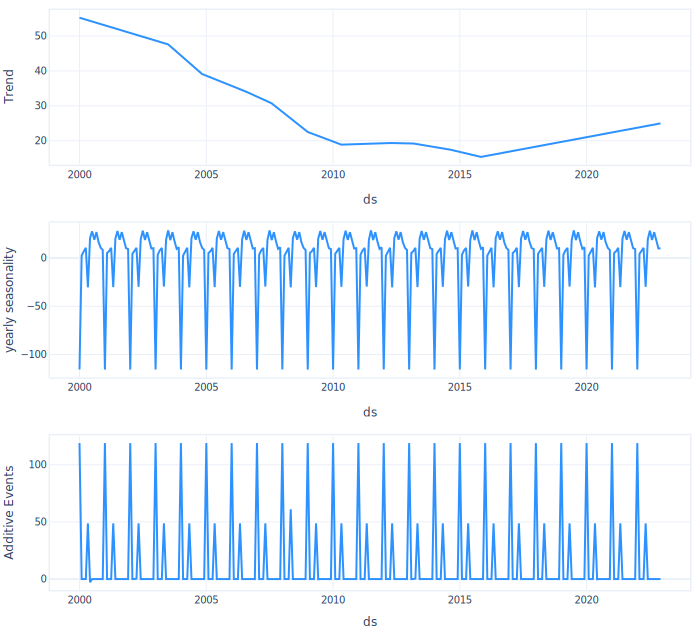

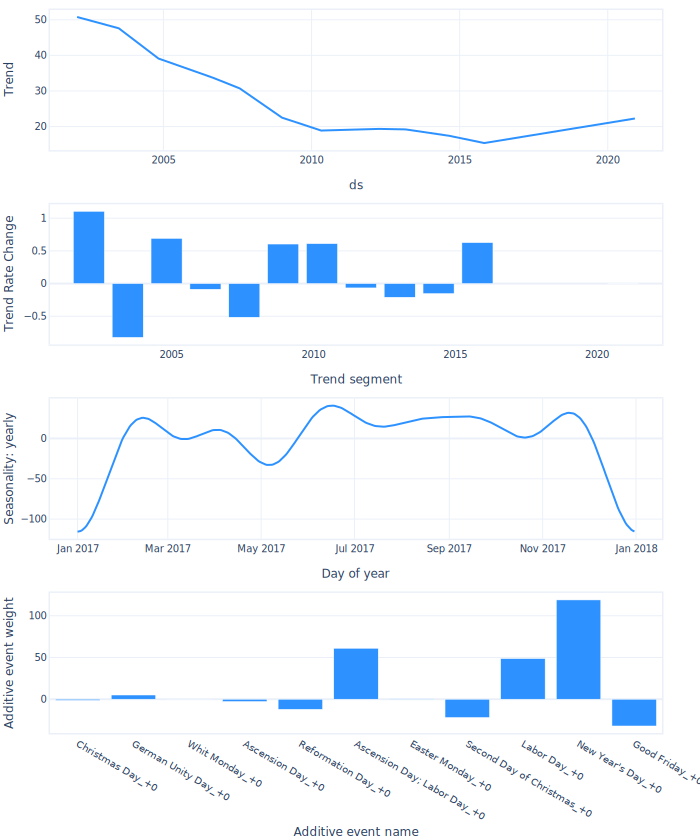

In [13]:
future = model.make_future_dataframe(data_train_val, periods=24, n_historic_predictions=len(data_train_val))
future.sort_values(by='ds', inplace=True, ascending=True)
future.reset_index(drop=True, inplace=True)
print(future)
forecast = model.predict(future)
print(forecast)

fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)
fig_model = model.plot_parameters()

Hyperparameter tuning using grid search.

In [ ]:
model = NeuralProphet(yearly_seasonality=True, seasonality_mode='additive')
data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.1)
print("Dataset size:", len(data))
print("Train dataset size:", len(data_train))
print("Validation dataset size:", len(data_val))

param_grid = {  
    'learning_rate': [0.001, 0.008, 0.01, 0.1],
    'normalize': ['minmax', 'soft', 'standardize'],
    'epochs': [300],
    'batch_size': [3, 6, 12]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

maes_train = []; rmses_train = []; maes_val = []; rmses_val = []

for params in all_params:
    m = NeuralProphet(**params, yearly_seasonality=True, seasonality_mode='additive') 
    m = m.add_country_holidays(country_name='DE')
    m.set_plotting_backend('plotly-static')
    metrics_train = m.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
    maes_train.append(metrics_train['MAE'].values[-1])
    rmses_train.append(metrics_train['RMSE'].values[-1])
    maes_val.append(metrics_train['MAE_val'].values[-1])
    rmses_val.append(metrics_train['RMSE_val'].values[-1])
    print(params)
    print('training MAE:' + str(metrics_train['MAE'].values[-1]))
    print('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
    print('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
    print('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
    print('---------------------------------')
    
tuning_results = pd.DataFrame(all_params)
tuning_results['MAE_train'] = maes_train
tuning_results['RMSE_train'] = rmses_train
tuning_results['MAE_val'] = maes_val
tuning_results['RMSE_val'] = rmses_val
tuning_results.sort_values(by='MAE_train', ascending=True, inplace=True)
tuning_results.reset_index(drop=True, inplace=True)
print(tuning_results)

best_params = all_params[np.argmin(maes_train)]
print(best_params)

Save model.

In [62]:
with open('./model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('./model.pkl', 'rb') as f:
    model = pickle.load(f)
    model.restore_trainer()

WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



In [38]:
save(model, "./model.np")

In [8]:
model = load("./model.np")

WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



In [9]:
future = model.make_future_dataframe(data, periods=12)
forecast = model.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency -31D corresponds to 57.955% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq MS. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 0it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,events_additive,event_Ascension Day,event_Ascension Day; Labor Day,event_Christmas Day,event_Easter Monday,event_German Unity Day,event_Good Friday,event_Labor Day,event_New Year's Day,event_Reformation Day,event_Second Day of Christmas,event_Whit Monday
0,2022-01-01,None,26.943470,36.103035,-28.444145,19.284582,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19.284582,0.0,0.0,0.0
1,2022-02-01,None,27.589596,36.216389,-8.626792,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,2022-03-01,None,30.974096,36.318771,-5.344676,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,2022-04-01,None,34.519810,36.432129,-1.912321,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,2022-05-01,None,42.805275,36.541828,2.120008,4.143439,0.0,0.0,0.0,0.0,0.0,0.0,4.143439,0.000000,0.0,0.0,0.0


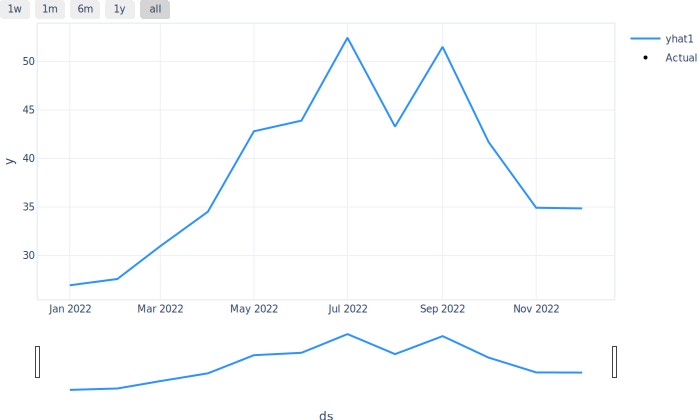

In [13]:
model.plot(forecast, plotting_backend='plotly-static')

Automated pipeline for all steps above.

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3855267/3871042053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name.sort_values(by='MONAT', inplace=True, ascending=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3855267/3871042053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name.sort_values(by='MONAT', inplace=True, ascending=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3855267/3871042053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

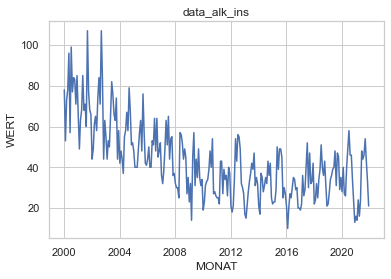

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.603]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


(252, 2)
(12, 2)
Dataset size: 264
Train dataset size: 215
Validation dataset size: 37


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")

Missing logger folder: /u/halle/zhouni/home_at/AccidPre/lightning_logs
INFO - (NP.df_utils._infer

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.015525534749031067
         MAE_val             7.91710901260376
        RMSE_val             9.362044334411621
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:5.73399543762207
training RMSE:6.779679298400879
validation MAE:8.260990142822266
validation RMSE:10.245092391967773
test MAE:7.91710901260376
test RMSE:9.362044334411621
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.02486957423388958
         MAE_val             9.755692481994629
        RMSE_val            11.848995208740234
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 6}
training MAE:11.272049903869629
training RMSE:14.513239860534668
validation MAE:10.9115571975708
validation RMSE:13.182690620422363
test MAE:9.755692481994629
test RMSE:11.848995208740234
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.02238335646688938
         MAE_val              9.2666597366333
        RMSE_val            11.241129875183105
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 12}
training MAE:7.050505638122559
training RMSE:9.05378246307373
validation MAE:9.566791534423828
validation RMSE:11.66066837310791
test MAE:9.2666597366333
test RMSE:11.241129875183105
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.03262932598590851
         MAE_val             8.139396667480469
        RMSE_val             9.780404090881348
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 3}
training MAE:5.8602681159973145
training RMSE:6.90680456161499
validation MAE:8.609564781188965
validation RMSE:10.624475479125977
test MAE:8.139396667480469
test RMSE:9.780404090881348
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.08170861750841141
         MAE_val            13.071563720703125
        RMSE_val             15.52849292755127
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 6}
training MAE:7.619273662567139
training RMSE:9.752593040466309
validation MAE:12.948275566101074
validation RMSE:14.785578727722168
test MAE:13.071563720703125
test RMSE:15.52849292755127
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.04376013204455376
         MAE_val             9.20925521850586
        RMSE_val             11.32640552520752
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'soft', 'epochs': 300, 'batch_size': 12}
training MAE:16.824621200561523
training RMSE:24.332260131835938
validation MAE:8.268790245056152
validation RMSE:10.092320442199707
test MAE:9.20925521850586
test RMSE:11.32640552520752
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.403291791677475
         MAE_val            10.035151481628418
        RMSE_val            12.117496490478516
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 3}
training MAE:6.999212741851807
training RMSE:8.472118377685547
validation MAE:10.618947982788086
validation RMSE:12.423089027404785
test MAE:10.035151481628418
test RMSE:12.117496490478516
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test            0.437915563583374
         MAE_val             10.79586410522461
        RMSE_val            12.878363609313965
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 6}
training MAE:7.290620803833008
training RMSE:9.270340919494629
validation MAE:11.157526969909668
validation RMSE:13.160948753356934
test MAE:10.79586410522461
test RMSE:12.878363609313965
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.4090939462184906
         MAE_val            10.294107437133789
        RMSE_val            12.479301452636719
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.001, 'normalize': 'standardize', 'epochs': 300, 'batch_size': 12}
training MAE:7.972209930419922
training RMSE:10.566045761108398
validation MAE:10.301481246948242
validation RMSE:12.032803535461426
test MAE:10.294107437133789
test RMSE:12.479301452636719
---------------------------------


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.535]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.019054213538765907
         MAE_val              8.7764253616333
        RMSE_val             10.37153148651123
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'learning_rate': 0.008, 'normalize': 'minmax', 'epochs': 300, 'batch_size': 3}
training MAE:5.588464260101318
training RMSE:6.6735358238220215
validation MAE:9.0449857711792
validation RMSE:11.0784330368042
test MAE:8.7764253616333
test RMSE:10.37153148651123
---------------------------------


WARNING - (py.warnings._showwarnmsg) - /u/halle/zhouni/home_at/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")



KeyError: 'MAE'

In [5]:
data = df.copy()

data_grouped = data.groupby(['MONATSZAHL', 'AUSPRAEGUNG'])

df_names = ['data_alk_ins', 'data_alk_vug', 'data_flu_ins', 'data_flu_vug', 'data_ver_ins', 'data_ver_mps', 'data_ver_vug']
df_list = []
count = 0

for i in range(len(data.MONATSZAHL.unique())):
    data_tmp = data[data['MONATSZAHL'] == data.MONATSZAHL.unique()[i]]
    for j in range(len(data_tmp.AUSPRAEGUNG.unique())):
        data_tmp_2 = data_grouped.get_group((data.MONATSZAHL.unique()[i], data_tmp.AUSPRAEGUNG.unique()[j]))
        df_name = df_names[count]
        df_name = data_tmp_2[['MONAT', 'WERT']]
        df_name.sort_values(by='MONAT', inplace=True, ascending=True)
        df_name.reset_index(drop=True, inplace=True)
        df_list.append(df_name)
        count += 1

sns.set(rc={'figure.figsize':(8, 4)})
sns.set_style("whitegrid")

logging.basicConfig(filename='./train_log/neuralprophet/train.log', encoding='utf-8', level=logging.INFO)
logger = logging.getLogger(__name__)

for i in range(len(df_list)):
    sns.lineplot(x='MONAT', y='WERT', data=df_list[i]).set_title(df_names[i])
    plt.savefig('./train_log/neuralprophet/' + df_names[i] +'.png')
    plt.show()
    
    data = df_list[i].copy()
    data.columns = ['ds', 'y']
    
    data_train_val = data[data['ds'] < '2021-01-01']
    data_train_val.reset_index(drop=True, inplace=True)
    data_train_val.to_csv('./data/' + df_names[i] + '.csv', index=False)
    logger.info(data_train_val.shape)
    print(data_train_val.shape)
    data_test = data[data['ds'] >= '2021-01-01']
    data_test.reset_index(drop=True, inplace=True)
    logger.info(data_test.shape)
    print(data_test.shape)
    
    model = NeuralProphet(yearly_seasonality=True, seasonality_mode='additive')
    data_train, data_val = model.split_df(data_train_val, freq='MS', valid_p=0.15)
    logger.info("Dataset size:" + str(len(data)))
    logger.info("Train dataset size:" + str(len(data_train)))
    logger.info("Validation dataset size:"+ str(len(data_val)))
    print("Dataset size:", len(data))
    print("Train dataset size:", len(data_train))
    print("Validation dataset size:", len(data_val))

    param_grid = {  
        'learning_rate': [0.001, 0.008, 0.01, 0.1],
        'normalize': ['minmax', 'soft', 'standardize'],
        'epochs': [300],
        'batch_size': [3, 6, 12]
    }

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    maes_train = []; rmses_train = []; maes_val = []; rmses_val = []; maes_test = []; rmses_test = []

    for params in all_params:
        m = NeuralProphet(**params, yearly_seasonality=True, seasonality_mode='additive') 
        m = m.add_country_holidays(country_name='DE')
        m.set_plotting_backend('plotly-static')
        metrics_train = m.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
        maes_train.append(metrics_train['MAE'].values[-1])
        rmses_train.append(metrics_train['RMSE'].values[-1])
        maes_val.append(metrics_train['MAE_val'].values[-1])
        rmses_val.append(metrics_train['RMSE_val'].values[-1])
        metrics_test = m.test(data_test)
        maes_test.append(metrics_test['MAE_val'].values[-1])
        rmses_test.append(metrics_test['RMSE_val'].values[-1])
        logger.info(params)
        logger.info('training MAE:' + str(metrics_train['MAE'].values[-1]))
        logger.info('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
        logger.info('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
        logger.info('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
        logger.info('test MAE:' + str(metrics_test['MAE_val'].values[-1]))
        logger.info('test RMSE:' + str(metrics_test['RMSE_val'].values[-1]))
        logger.info('---------------------------------')
        print(params)
        print('training MAE:' + str(metrics_train['MAE'].values[-1]))
        print('training RMSE:' + str(metrics_train['RMSE'].values[-1]))
        print('validation MAE:' + str(metrics_train['MAE_val'].values[-1]))
        print('validation RMSE:' + str(metrics_train['RMSE_val'].values[-1]))
        print('test MAE:' + str(metrics_test['MAE_val'].values[-1]))
        print('test RMSE:' + str(metrics_test['RMSE_val'].values[-1]))
        print('---------------------------------')
        
    tuning_results = pd.DataFrame(all_params)
    tuning_results['MAE_train'] = maes_train
    tuning_results['RMSE_train'] = rmses_train
    tuning_results['MAE_val'] = maes_val
    tuning_results['RMSE_val'] = rmses_val
    tuning_results['MAE_test'] = maes_test
    tuning_results['RMSE_test'] = rmses_test
    tuning_results.sort_values(by='RMSE_test', ascending=True, inplace=True)
    tuning_results.reset_index(drop=True, inplace=True)
    logger.info(tuning_results)
    print(tuning_results)

    best_params = all_params[np.argmin(rmses_test)]
    logger.info(best_params)
    print(best_params)
    
    model = NeuralProphet(**best_params, yearly_seasonality=True, seasonality_mode='additive') 
    model = model.add_country_holidays(country_name='DE')
    model.set_plotting_backend('plotly-static')
    metrics_train = model.fit(data_train, validation_df=data_val, freq='MS', early_stopping=False, progress=False)
    logger.info(metrics_train)
    print(metrics_train)
    
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(metrics_train["MAE"], '-o', label="Training Loss")  
    ax.plot(metrics_train["MAE_val"], '-r', label="Validation Loss")
    ax.legend(loc='center right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel("Epoch", fontsize=28)
    ax.set_ylabel("Loss", fontsize=28)
    plt.savefig('./train_log/neuralprophet/loss_' + df_names[i][5:] +'.png')
    plt.show()
    
    forecast = model.predict(data_test)
    model.plot(forecast)

    metrics_test = model.test(data_test)
    logger.info(metrics_test)
    print(metrics_test)
    
    forecast = model.predict(data_test)
    model.plot(forecast)
    #plt.savefig('./train_log/neuralprophet/forecast_' + df_names[i][5:] +'.png')

    metrics_test = model.test(data_test)
    logger.info(metrics_test)
    print(metrics_test)
    
    future = model.make_future_dataframe(data_train_val, periods=24, n_historic_predictions=len(data_train_val))
    future.sort_values(by='ds', inplace=True, ascending=True)
    future.reset_index(drop=True, inplace=True)
    logger.info(future)
    print(future)
    forecast = model.predict(future)
    logger.info(forecast)
    print(forecast)

    fig_forecast = model.plot(forecast)
    fig_components = model.plot_components(forecast)
    fig_model = model.plot_parameters()
    
    save(model, './models/neuralprophet/model_' + df_names[i][5:] +'.np')
    logger.info('model_'+ df_names[i][5:] +' saved.')

2. Machine Learning model (XGBoost).